# Demonstrates use of LSTM with multiple channels

## Initialize

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline
import tensorflow as tf
import os
import matplotlib.pyplot as plt, numpy as np,  pandas as pd
from sklearn.preprocessing import MinMaxScaler

root_notebook_folder = os.path.abspath('.')
data_folder = os.path.abspath('./local_data')

## Load data

### Prepare holidays dataset
The following code generates a table of public holidays in Israel. It relies on <code>workalendar</code> library located at https://pypi.org/project/workalendar/<br>
<code>pip install workalendar</code>

In [2]:
calendar_file_name = os.path.join(data_folder, 'IsraeliHolidays.csv')
if not os.path.isfile(calendar_file_name):
    from workalendar.asia import Israel
    calendar = Israel()
    holidays = []
    for year in range(2000, 2021 ):
        holidays += calendar.holidays(year)
    holidays = pd.DataFrame(holidays, columns=['Date', 'Holiday Name'])
    holidays.to_csv( os.path.join(data_folder, 'IsraeliHolidays.csv'), index=None)

### Load raw data

In [3]:
data_file_name = os.path.join(data_folder, 'ER admission_1.csv')
raw_data = pd.read_csv(data_file_name)
raw_data['t'] = pd.to_datetime(raw_data['t'])
raw_data = raw_data.reset_index(drop=True).set_index('t')
raw_data.head()

,n
t,
2004-01-01 00:00:00,5
2004-01-01 01:00:00,8
2004-01-01 02:00:00,8
2004-01-01 03:00:00,8
2004-01-01 04:00:00,0


### generate additional columns

In [4]:
data_file_name = os.path.join(data_folder, 'ER admission_1.csv')
raw_data = pd.read_csv(data_file_name)

raw_data['t'] = pd.to_datetime(raw_data['t'])
raw_data['weekday'] = raw_data['t'].apply(lambda x: x.weekday())
raw_data['hour'] = raw_data['t'].apply(lambda x: x.hour)
        
holidays = pd.read_csv( os.path.join(data_folder, 'IsraeliHolidays.csv') )
holidays['Date'] = pd.to_datetime(holidays['Date']).apply(lambda x: x.date())
raw_data['is_holiday'] = raw_data['t'].apply(lambda x: x.date()).isin(holidays['Date']).astype(np.float32)

raw_data= raw_data.reset_index(drop=True).set_index('t')        
        
raw_data = pd.get_dummies(raw_data, columns=['weekday', 'hour'], dtype=np.float32)

In [5]:
raw_data.shape

(34320, 33)

In [6]:
raw_data.head()

,n,is_holiday,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,hour_0,...,hour_14,hour_15,hour_16,hour_17,hour_18,hour_19,hour_20,hour_21,hour_22,hour_23
t,,,,,,,,,,,,,,,,,,,,,
2004-01-01 00:00:00,5,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 01:00:00,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 02:00:00,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 03:00:00,8,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2004-01-01 04:00:00,0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Split data into test and train, normalize the 'n' column

In [7]:
def sliding_windows(data, history_samples, horizon_samples):
    x = []
    y = []

    for i in range(len(data)-history_samples-horizon_samples):
        _x = data.iloc[i:(i+history_samples)]
        _y = data.iloc[i+history_samples:i+history_samples+horizon_samples, 0:1]
        x.append(_x)
        y.append(_y)
    return np.array(x),np.array(y)


In [8]:
history_samples=24*14
horizon_samples=24*3

# split into train and test sets
train_size = int(len(raw_data) * 0.9)-(history_samples+horizon_samples)
test_size = len(raw_data) - (train_size  + history_samples + horizon_samples)

train_data = raw_data.iloc[:train_size].copy()
test_data = raw_data.iloc[-test_size:].copy()

#normalize the data:
sc = MinMaxScaler()
sc.fit(train_data[['n']] )

train_data[['n']] = sc.transform(train_data[['n']] )
test_data[['n']] = sc.transform(test_data[['n']] )

# create train and test sets
trainX, trainY = sliding_windows(train_data, history_samples, horizon_samples)
#trainY = trainY[:,0:1]

testX, testY = sliding_windows(test_data, history_samples, horizon_samples)
#testY = testY[:,0:1]

In [9]:
testX.shape

(3024, 336, 33)

In [10]:
print(f'Data set: {len(raw_data)}. history size: {history_samples}. Prediction window size: {horizon_samples} ')
print(f'Data set: \t From: {raw_data.index[0]} to {raw_data.index[-1]}')
print(f"Train set: {len(train_data)}: from {train_data.index[0]} to: {train_data.index[-1]}")
print(f"Test set: {len(test_data)}: from {test_data.index[0]} to: {test_data.index[-1]}")
print(f"sample size: x: {trainX[0].shape}, y: {trainY[0].shape}")

Data set: 34320. history size: 336. Prediction window size: 72 
Data set: 	 From: 2004-01-01 00:00:00 to 2007-11-30 23:00:00
Train set: 30480: from 2004-01-01 00:00:00 to: 2007-06-23 23:00:00
Test set: 3432: from 2007-11-07 00:00:00 to: 2007-11-30 23:00:00
sample size: x: (336, 33), y: (72, 1)


## Define and train the model

### Define the network

In [11]:
def generate_model(lstm_hidden_dim, num_lstm_layers, output_dim):
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM,  Dense, Reshape
    model =  Sequential()
    for lstm_layer_index in range(num_lstm_layers):
        is_last_layer = (lstm_layer_index + 1) < num_lstm_layers
        model.add(LSTM(units=lstm_hidden_dim, return_sequences=is_last_layer , activation="tanh") ) 
    model.add(Dense(300, activation="relu"))
    model.add(Dense(100, activation="relu"))
    model.add(Dense(output_dim, activation=None))
    model.add(Reshape( (output_dim, 1)))
    return model

### Train the network
~4.5min

In [12]:
model_file_name = os.path.join(data_folder, 'ER Admission - LSTM-2')
model = generate_model(lstm_hidden_dim=100, num_lstm_layers=1, output_dim =testY.shape[1])
if not os.path.isdir(model_file_name):    
    model.compile(loss='mean_squared_error', optimizer='adam')
    history = model.fit(trainX, trainY, validation_data=(testX, testY), epochs=15, batch_size=200, verbose=1)    
    pd.DataFrame(history.history).to_csv(model_file_name + '.csv')
    model.save(model_file_name)        
model = tf.keras.models.load_model(model_file_name)
history = pd.read_csv(model_file_name + '.csv', index_col=0)

Text(0, 0.5, 'MSE')

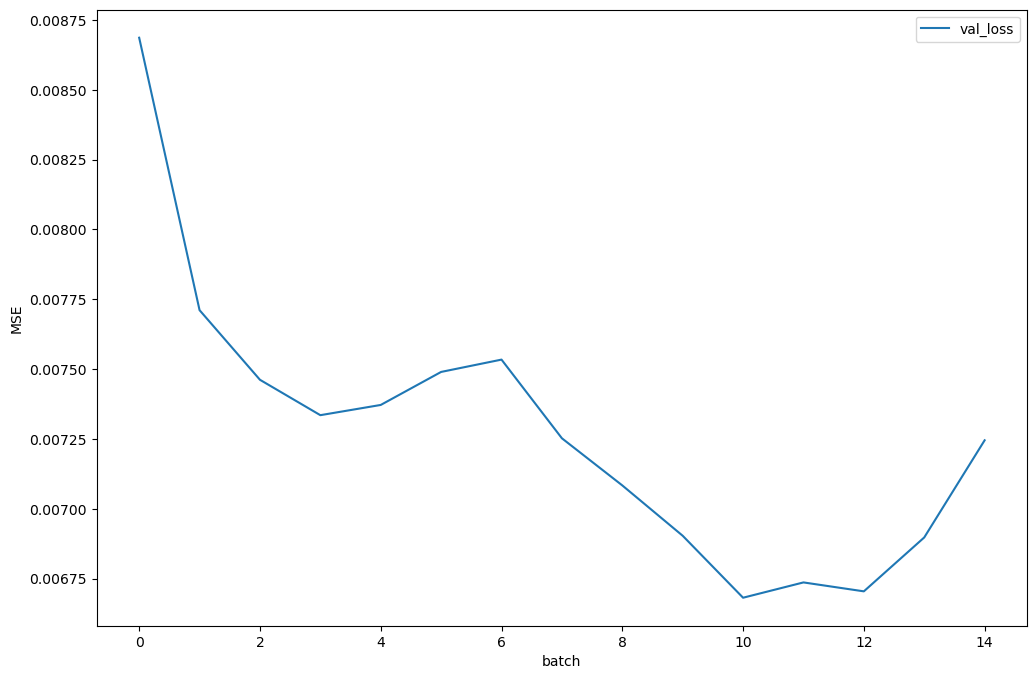

In [13]:
fig, ax = plt.subplots(figsize=(12,8))
history[['val_loss']].plot(ax=ax)
ax.set_xlabel('batch'); ax.set_ylabel('MSE')

## Explore the model

### Compute average accuracy

In [14]:
test_accuracy = model.evaluate(testX, testY)
print(f"test accuracy: {test_accuracy}")

95/95 [==============================] - 5s 51ms/step - loss: 0.0072
test accuracy: 0.007245402317494154


### Predicting the future

1/1 [==============================] - 0s 399ms/step


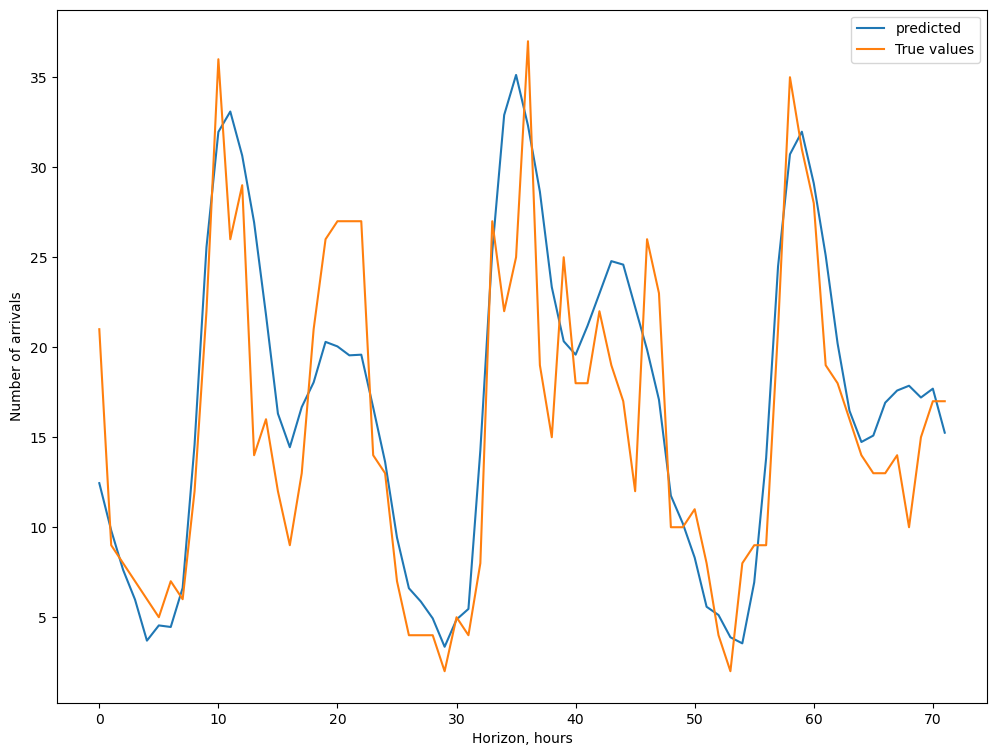

In [15]:
predY = model.predict(testX[0:1]).reshape(-1,1)
trueY = testY[0:1].reshape(-1,1)
plt.figure(figsize=(12,9))
plt.plot(sc.inverse_transform(predY), label='predicted')
plt.plot(sc.inverse_transform(trueY), label='True values')
plt.xlabel('Horizon, hours');
plt.ylabel('Number of arrivals');
plt.legend()

### Prediction of the first point

7/7 [==============================] - 0s 45ms/step


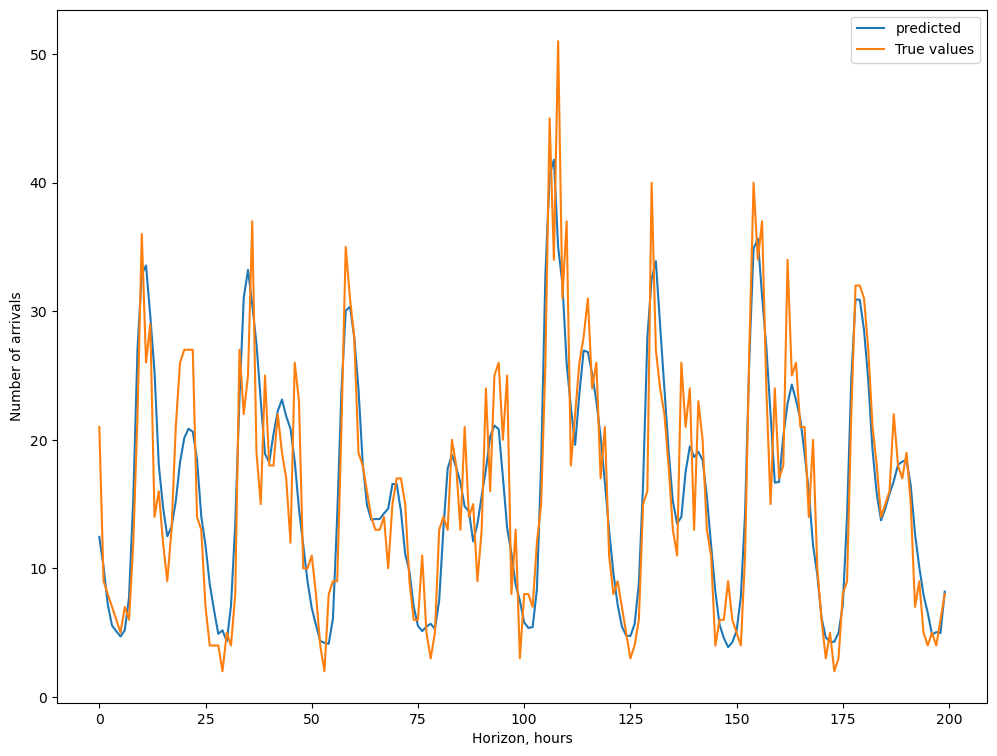

In [16]:
time_offset = 0
predY = model.predict(testX[0:200])[:,time_offset] # extract only the first time point for each of the 200 predictions. 
trueY = testY[0:200][:,time_offset]
plt.figure(figsize=(12,9))
plt.plot(sc.inverse_transform(predY), label='predicted')
plt.plot(sc.inverse_transform(trueY), label='True values')
plt.xlabel('Horizon, hours');
plt.ylabel('Number of arrivals');
plt.legend()

### Compute MSE over prediction horizon
Note that the  model produces prediction for 72h into the future. The current loss minimizes the average means square error.<br>
In general, we expect the accuracy to drop as prediction range increases. 

In [17]:
from sklearn.metrics import mean_squared_error
predY = model.predict(testX, batch_size=200) # extract only the first time point for each of the 200 predictions. 
trueY = testY
mse = np.zeros( (predY.shape[1],) , dtype=np.float32)
for time_offset in range(predY.shape[1]):
    mse[time_offset] = mean_squared_error(y_true=trueY[:,time_offset, 0], y_pred= predY[:,time_offset, 0])

16/16 [==============================] - 9s 551ms/step


Text(0, 0.5, 'MSE')

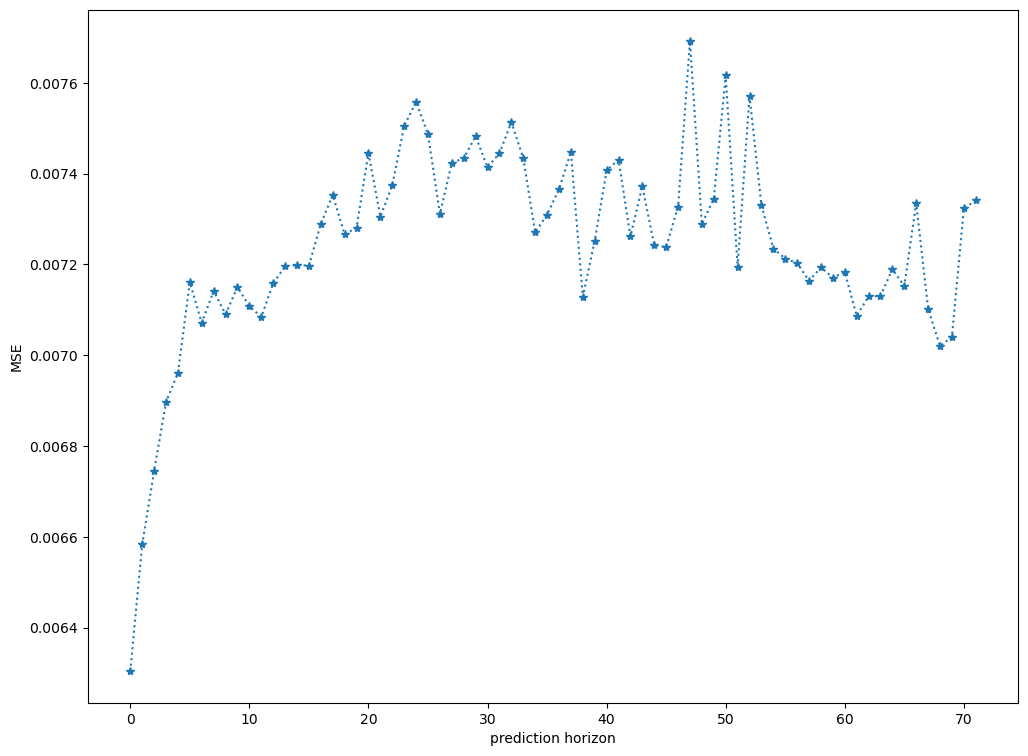

In [18]:
plt.figure(figsize=(12,9))
plt.plot(mse, '*:')
plt.xlabel('prediction horizon')
plt.ylabel('MSE')